# PROJECT 1: DATA ANALYSIS PROJECT

**Table of contents**<a id='toc0_'></a>    
- 1. [Aggregate inflation in Denmark](#toc1_)    
  - 1.1. [Basics](#toc1_1_)    
  - 1.2. [Instantaneous inflation](#toc1_2_)    
  - 1.3. [Core inflation](#toc1_3_)    
  - 1.4. [Disaggregated inflation in Denmark](#toc1_4_)      
- 2. [International Comparison](#toc2_)    
  - 2.1. [CPI vs HICP](#toc2_1_)    
  - 2.2. [Across countries](#toc2_2_)    
- 3. [Extension](#toc2_)  

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [25]:
# Importing packages
import numpy as np
import pandas as pd
from IPython.display import display
import Aflevering as py

import matplotlib.pyplot as plt
plt.rcParams.update({'axes.grid':True,'grid.color':'black','grid.alpha':'0.25','grid.linestyle':'--'})
plt.rcParams.update({'font.size': 14})

from dstapi import DstApi

## 1. <a id='toc1_'></a>[Aggregate inflation in Denmark](#toc0_)

In [26]:
# Setting up dictionaries for renaming columns and variables for the PRIS113 database
columns_dict = {}
columns_dict['TYPE'] = 'variable'
columns_dict['MÅNED'] = 'month'
columns_dict['INDHOLD'] = 'value'

var_dict = {}
var_dict['Forbrugerprisindeks'] = 'CPI'

In [27]:
# Downloading data from PRIS113 database using dstapi
API = DstApi('PRIS113') 
params = API._define_base_params(language='en')
display(params)
API = API.get_data(params)

{'table': 'pris113',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'TYPE', 'values': ['*']},
  {'code': 'Tid', 'values': ['*']}]}

In [28]:
# Renaming columns and variables from the PRIS113 database to the dictionaries defined above
API = API.rename(columns=columns_dict)
for key, value in var_dict.items():
    API.variable.replace(key, value, inplace=True)

API['value'] = pd.to_numeric(API['value'])

API.head()

/var/folders/77/y_wqkb2d7nvcjj1l7m69s8cc0000gn/T/ipykernel_7834/2493319037.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  API.variable.replace(key, value, inplace=True)


,variable,TID,value
0,Consumer price index,1980M01,33.0
1,Consumer price index,1980M05,34.5
2,Consumer price index,1980M09,35.5
3,Consumer price index,1981M01,36.5
4,Consumer price index,1981M05,38.6


In [30]:
# Renaming TID to Time and converting to datetime
API['date'] = pd.to_datetime(API['TID'], format='%YM%m')
API['year'] = API.date.dt.year
API['month'] = API.date.dt.month

# Dropping TID colonen
API = API.drop(columns=['TID'])

# Se datasættet
API.head()

,variable,value,date,year,month
0,Consumer price index,33.0,1980-01-01,1980,1
1,Consumer price index,34.5,1980-05-01,1980,5
2,Consumer price index,35.5,1980-09-01,1980,9
3,Consumer price index,36.5,1981-01-01,1981,1
4,Consumer price index,38.6,1981-05-01,1981,5


In [33]:
# Sort after date
API = API.sort_values('date').reset_index(drop=True)
# Verifify that it's sorted
API[['date', 'year', 'month', 'value']].head(10)

,date,year,month,value
0,1980-01-01,1980,1,33.0
1,1980-02-01,1980,2,33.3
2,1980-03-01,1980,3,33.8
3,1980-04-01,1980,4,34.0
4,1980-05-01,1980,5,34.5
5,1980-06-01,1980,6,34.6
6,1980-07-01,1980,7,35.2
7,1980-08-01,1980,8,35.3
8,1980-09-01,1980,9,35.5
9,1980-10-01,1980,10,35.8


### 1.1. <a id='toc1_1_'></a>[Basics](#toc0_)

Gennemsnitlig CPI i 2020: 103.43


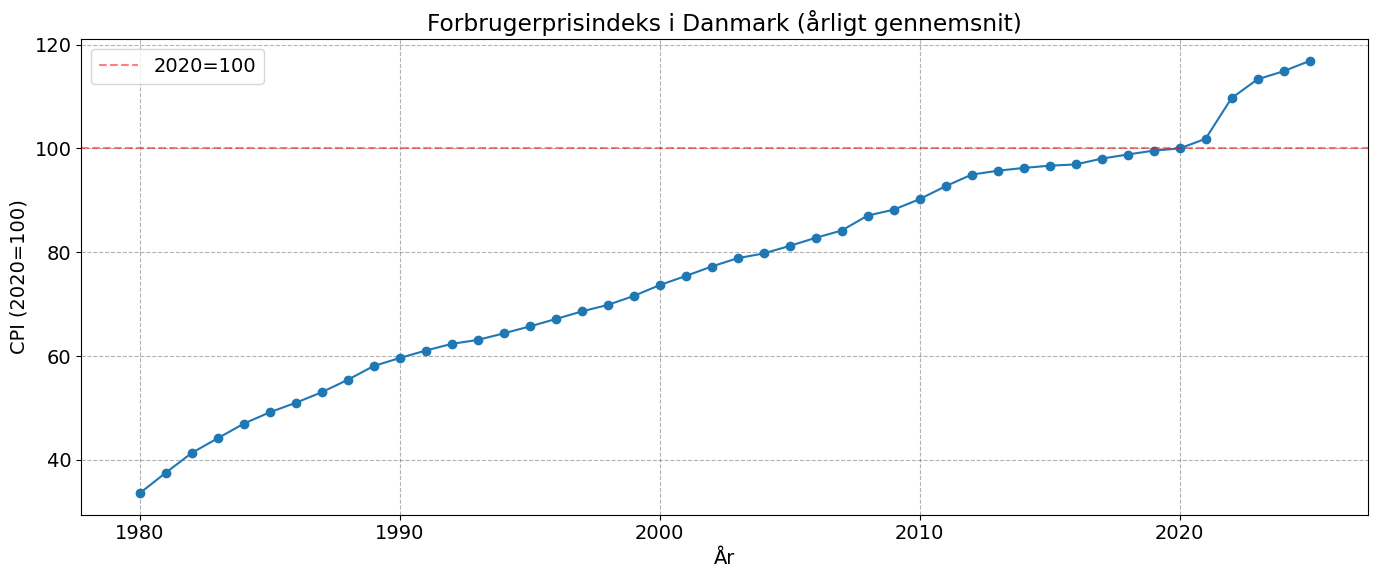

In [ ]:
# Calculated the consumer price index (CPI), P_t, indexed to 100 on average in 2020
cpi_2020_avg = API[API['year'] == 2020]['value'].mean()
print(f"Gennemsnitlig CPI i 2020: {cpi_2020_avg:.2f}")

# Calculate 
# Beregn P_t for alle år
API['P_t'] = (API['value'] / cpi_2020_avg) * 100

# Se resultatet
API[['date', 'year', 'value', 'P_t']].head(10)
API[['date', 'year', 'value', 'P_t']].tail(10)

# Beregn årligt gennemsnit
API_yearly = API.groupby('year')['P_t'].mean().reset_index()

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(API_yearly['year'], API_yearly['P_t'], marker='o')
ax.set_xlabel('År')
ax.set_ylabel('CPI (2020=100)')
ax.set_title('Forbrugerprisindeks i Danmark (årligt gennemsnit)')
ax.axhline(y=100, color='red', linestyle='--', alpha=0.5, label='2020=100')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

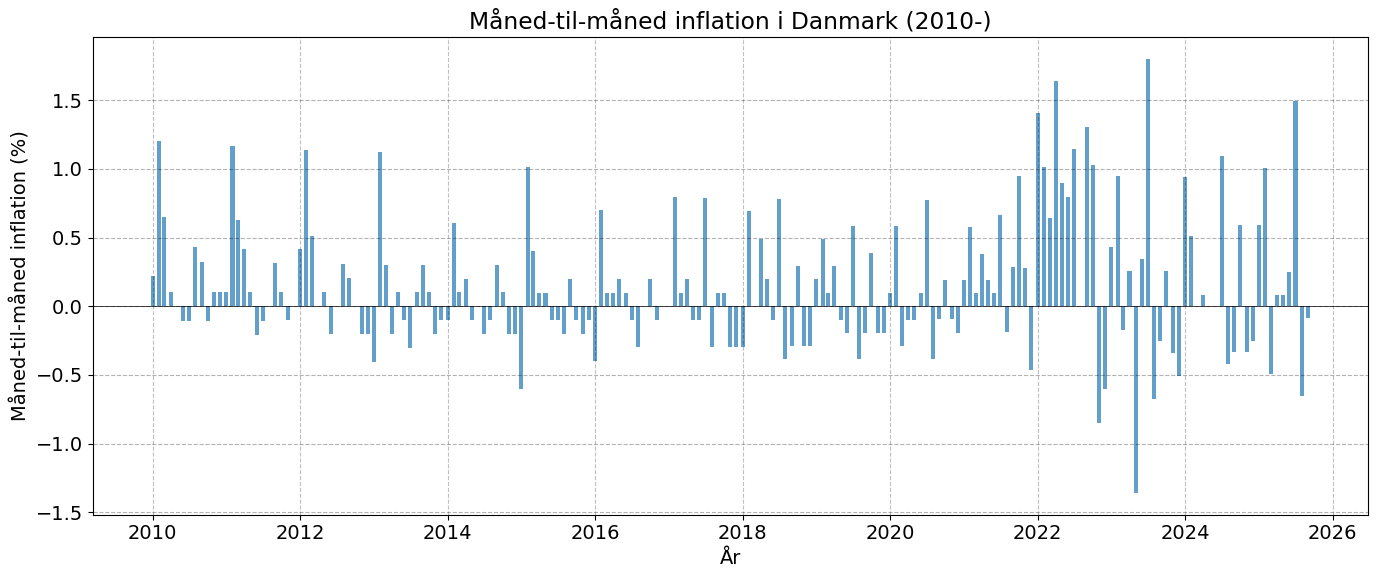

In [119]:
# Beregn π_t = value_t / value_{t-1} - 1
API['pi_t'] = API['value'] / API['value'].shift(1) - 1

# Se resultatet
API[['date', 'year', 'value', 'pi_t']].tail(20)

# Filtrer fra 2010
API_2010 = API[API['year'] >= 2010]

# Plot som barchart
fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(API_2010['date'], API_2010['pi_t'] * 100, width=20, alpha=0.7)
ax.set_xlabel('År')
ax.set_ylabel('Måned-til-måned inflation (%)')
ax.set_title('Måned-til-måned inflation i Danmark (2010-)')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

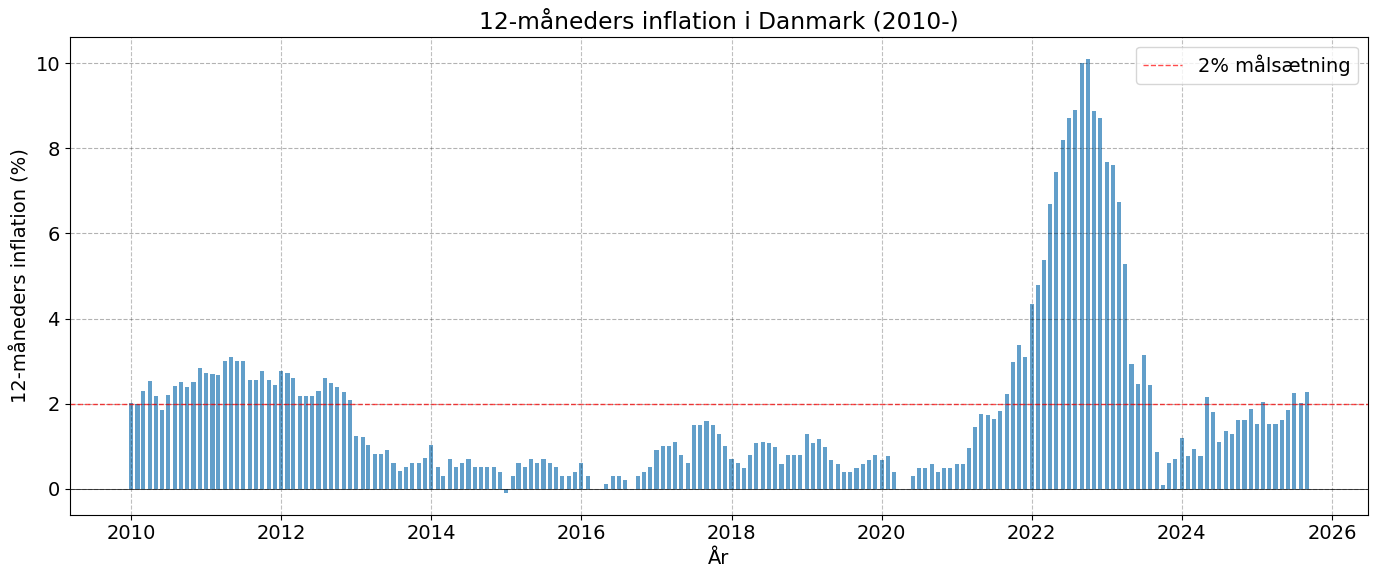

In [141]:
# Beregn π_t^12 = value_t / value_{t-12} - 1
API['pi_t_12'] = API['value'] / API['value'].shift(12) - 1

# Se resultatet
API[['date', 'year', 'value', 'pi_t_12']].tail(20)

# Filtrer fra 2010
API_2010 = API[API['year'] >= 2010]

# Plot som barchart
fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(API_2010['date'], API_2010['pi_t_12'] * 100, width=20, alpha=0.7)
ax.set_xlabel('År')
ax.set_ylabel('12-måneders inflation (%)')
ax.set_title('12-måneders inflation i Danmark (2010-)')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.axhline(y=2, color='red', linestyle='--', linewidth=1, alpha=0.7, label='2% målsætning')
ax.grid(True, alpha=0.3, axis='y')
ax.legend()
plt.tight_layout()
plt.show()

***1.2: Instantaneous inflation***

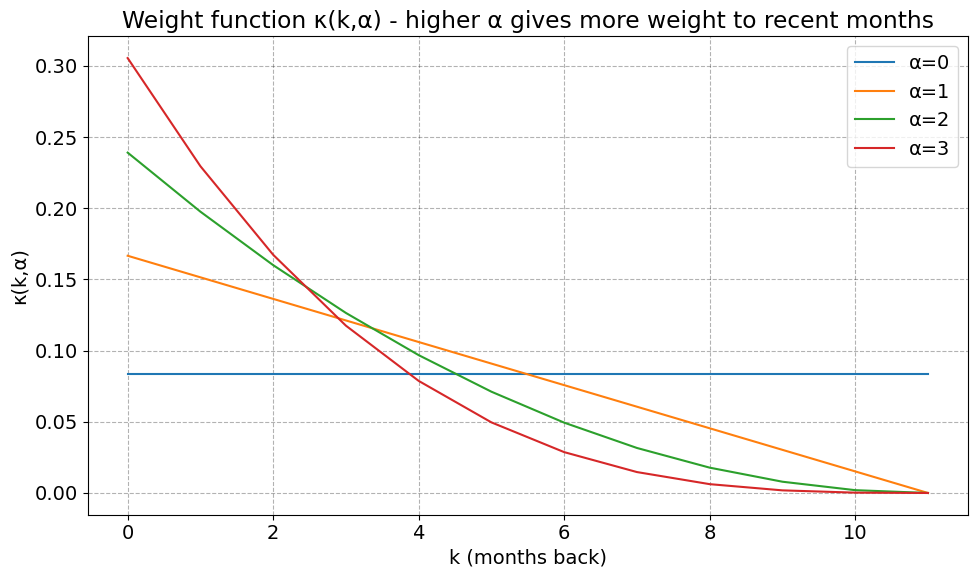

In [ ]:
# 1. Plotting κ(k,α)
T = 11
k_values = np.arange(0, 12)
alpha_values = [0, 1, 2, 3]

def compute_kappa(k, alpha, T=11):
    """Beregn vægtfunktion κ(k, α)"""
    if alpha == 0:
        return 1/12  # Lige vægtning når α=0
    numerator = (T - k)**alpha
    denominator = sum((T - j)**alpha for j in range(12))
    return numerator / denominator

# Plot κ(k,α)
fig, ax = plt.subplots(figsize=(10, 6))
for alpha in alpha_values:
    kappas = [compute_kappa(k, alpha) for k in k_values]
    ax.plot(k_values, kappas, marker='', label=f'α={alpha}')

ax.set_xlabel('k (months back)')
ax.set_ylabel('κ(k,α)')
ax.set_title('Weight function κ(k,α) - higher α gives more weight to recent months')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Comparison α=0 vs standard 12-month inflation:
          date   pi_t_12  pi_inst_alpha_0  difference
539 2024-12-01  0.018852         0.001558    0.017294
540 2025-01-01  0.015280         0.001265    0.014016
541 2025-02-01  0.020270         0.001674    0.018597
542 2025-03-01  0.015203         0.001258    0.013945
543 2025-04-01  0.015190         0.001257    0.013933
544 2025-05-01  0.016034         0.001326    0.014707
545 2025-06-01  0.018565         0.001534    0.017031
546 2025-07-01  0.022538         0.001859    0.020679
547 2025-08-01  0.020117         0.001661    0.018456
548 2025-09-01  0.022708         0.001873    0.020835


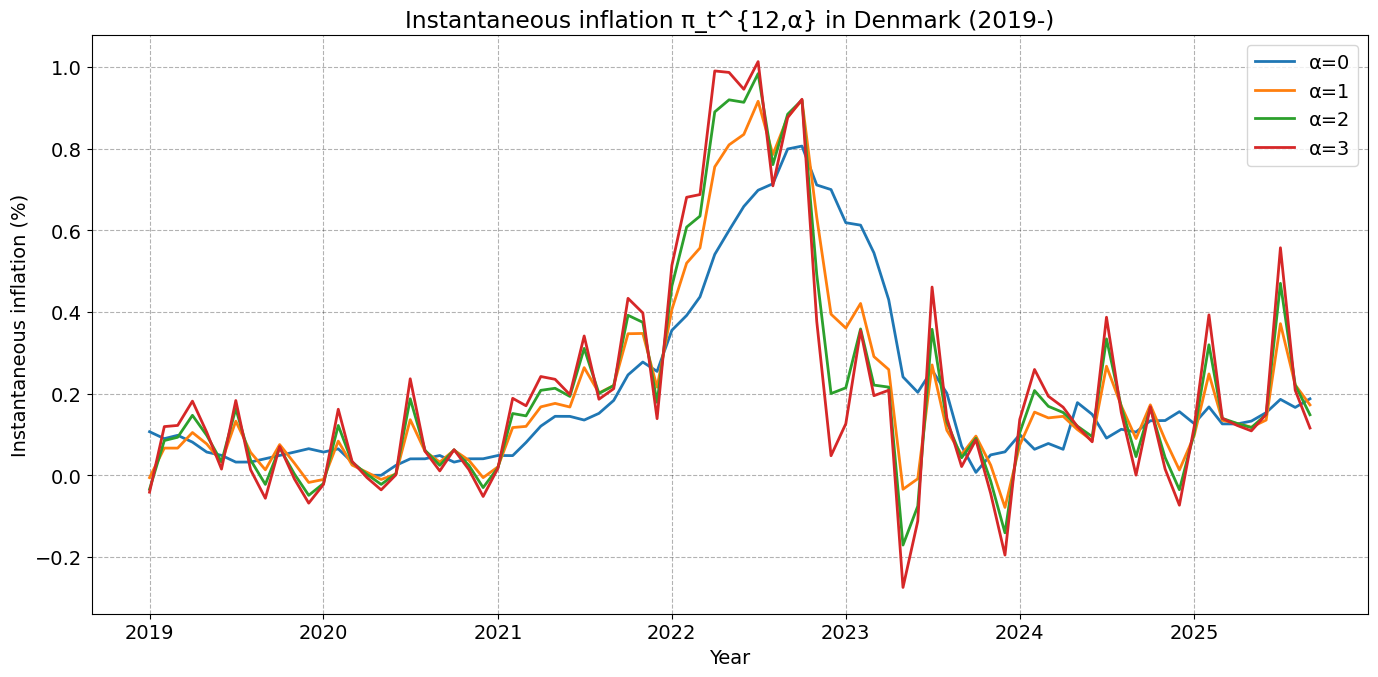


When did inflation peak for different α values:
α=0: 2022-10, 0.81%
α=1: 2022-10, 0.92%
α=2: 2022-07, 0.98%
α=3: 2022-07, 1.01%


In [142]:

# 2. Compute π_t^{12,α} using rolling method
def compute_instantaneous_inflation_rolling(pi_t, alpha):
    """
    Compute π_t^{12,α} using rolling window
    pi_t: monthly inflation rates (as decimals)
    """
    def weighted_inflation(window):
        if len(window) < 12:
            return np.nan
        # Window is ordered oldest to newest, reverse to match k indexing
        # where k=0 is most recent
        window_reversed = window[::-1]
        # Compute weighted geometric mean: ∏(1 + π_t-k)^κ(k,α) - 1
        weights = [compute_kappa(k, alpha) for k in range(12)]
        product = np.prod((1 + window_reversed) ** weights)
        return product - 1
    
    return pi_t.rolling(window=12).apply(weighted_inflation, raw=True)

# Calculate for all α values
for alpha in alpha_values:
    API[f'pi_inst_alpha_{alpha}'] = compute_instantaneous_inflation_rolling(API['pi_t'], alpha)

# Verify that at α=0, it gives the same result as standard 12-month inflation
print("Comparison α=0 vs standard 12-month inflation:")
comparison = API[['date', 'pi_t_12', 'pi_inst_alpha_0']].tail(10)
comparison['difference'] = comparison['pi_t_12'] - comparison['pi_inst_alpha_0']
print(comparison)

# 3. Plot since 2019
API_2019 = API[API['year'] >= 2019]
fig, ax = plt.subplots(figsize=(14, 7))

for alpha in alpha_values:
    ax.plot(API_2019['date'], API_2019[f'pi_inst_alpha_{alpha}'] * 100,
            label=f'α={alpha}', linewidth=2)

ax.set_xlabel('Year')
ax.set_ylabel('Instantaneous inflation (%)')
ax.set_title('Instantaneous inflation π_t^{12,α} in Denmark (2019-)')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

# Find when inflation peaked for different α values
print("\nWhen did inflation peak for different α values:")
for alpha in alpha_values:
    post_2020 = API[API['year'] >= 2020]
    peak_idx = post_2020[f'pi_inst_alpha_{alpha}'].idxmax()
    peak_data = post_2020.loc[peak_idx]
    print(f"α={alpha}: {peak_data['date'].strftime('%Y-%m')}, {peak_data[f'pi_inst_alpha_{alpha}']*100:.2f}%")

In [ ]:
# 3. Plot siden 2019
API_2019 = API[API['year'] >= 2019]

fig, ax = plt.subplots(figsize=(14, 7))
for alpha in alpha_values:
    ax.plot(API_2019['date'], API_2019[f'pi_inst_alpha_{alpha}'] * 100, 
            label=f'α={alpha}', linewidth=2)

ax.set_xlabel('År')
ax.set_ylabel('Instantaneous inflation (%)')
ax.set_title('Instantaneous inflation π_t^{12,α} i Danmark (2019-)')
ax.axhline(y=2, color='red', linestyle='--', linewidth=1, alpha=0.7, label='2% målsætning')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

# Find hvornår inflationen toppede for forskellige α
print("\nHvornår toppede inflationen for forskellige α:")
for alpha in alpha_values:
    post_2020 = API[API['year'] >= 2020]
    peak_idx = post_2020[f'pi_inst_alpha_{alpha}'].idxmax()
    peak_data = post_2020.loc[peak_idx]
    print(f"α={alpha}: {peak_data['date'].strftime('%Y-%m')}, {peak_data[f'pi_inst_alpha_{alpha}']*100:.2f}%")

**Del 1.3** 

In [ ]:
columns_dict = {}
columns_dict['VAREGR'] = 'category'
columns_dict['ENHED'] = 'unit'
columns_dict['MÅNED'] = 'month'
columns_dict['INDHOLD'] = 'value'

category_dict = {}
category_dict['00 Consumer price index, total'] = 'Total_CPI'
category_dict['15.1 Overall Consumer Price Index excl. energy'] = 'Excl_energy'
category_dict['14.1 Overall Consumer Price Index - excl. energy and unprocessed food (core inflation)'] = 'Core_inflation'

unit_dict = {}
unit_dict['Index'] = 'index'

In [130]:
API_111 = DstApi('PRIS111')
params = API_111._define_base_params(language='en')

# Hent al data først
API_111 = API_111.get_data(params)

# Se kolonnerne
print("Kolonnenavne:")
print(API_111.columns)
print("\n")
print(API_111.head(20))

# Se hvilke kategorier der er
print("\nUnikke VAREGR værdier:")
print(API_111['VAREGR'].unique()[:10])

print("\nUnikke ENHED værdier:")
print(API_111['ENHED'].unique())

Kolonnenavne:
Index(['VAREGR', 'ENHED', 'TID', 'INDHOLD'], dtype='object')


                                               VAREGR  \
0                                      05.3.2.3 Irons   
1                        05.3.2.4 Toasters and grills   
2                        05.3.2.4 Toasters and grills   
3                        05.3.2.4 Toasters and grills   
4   05.3.2.9 Other small electric household applia...   
5   05.3.2.9 Other small electric household applia...   
6   05.3.2.9 Other small electric household applia...   
7               05.3.3 Repair of household appliances   
8               05.3.3 Repair of household appliances   
9               05.3.3 Repair of household appliances   
10   05.4 Glassware, tableware and household utensils   
11   05.4 Glassware, tableware and household utensils   
12   05.4 Glassware, tableware and household utensils   
13  05.4.0.1 Glassware, crystal-ware, ceramic ware...   
14  05.4.0.1 Glassware, crystal-ware, ceramic ware...   
15  05.4.0.

In [ ]:
API_111 = DstApi('PRIS111')
params = API_111._define_base_params(language='en')

# Ret måde at ændre params på
for var in params['variables']:
    if var['code'] == 'VAREGR':
        var['values'] = [
            '00 Consumer price index, total',
            '15.1 Overall Consumer Price Index excl. energy',
            '14.1 Overall Consumer Price Index - excl. energy and unprocessed food (core inflation)'
        ]
    elif var['code'] == 'ENHED':
        var['values'] = ['Index']

display(params)
API_111 = API_111.get_data(params)

# Brug dine dictionaries til at omdøbe
API_111 = API_111.rename(columns=columns_dict)
for key, value in category_dict.items():
    API_111.category.replace(key, value, inplace=True)
for key, value in unit_dict.items():
    API_111.unit.replace(key, value, inplace=True)

API_111.head()


In [ ]:
# Se alle unikke kategorier i dit data - her finde rjeg den første værdi, som jeg skal have fat i 
print("Alle kategorier i API_111:")
all_cats = sorted(API_111['VAREGR'].unique())

# Print de første 30
for i, cat in enumerate(all_cats[:30]):
    print(f"{i}: {cat}")

Alle kategorier i API_111:
0: 00 Consumer price index, total
1: 01 Food and non-alcoholic beverages
2: 01.1 Food
3: 01.1.1 Bread and cereals
4: 01.1.1.1 Rice
5: 01.1.1.2 Flours and other cereals
6: 01.1.1.3 Bread
7: 01.1.1.4 Other bakery products
8: 01.1.1.5 Pizza and quiche
9: 01.1.1.6 Pasta products and couscous
10: 01.1.1.7 Breakfast cereals
11: 01.1.1.8 Other cereal products
12: 01.1.2 Meat
13: 01.1.2.1 Beef and veal
14: 01.1.2.2 Pork
15: 01.1.2.3 Lamb and goat
16: 01.1.2.4 Poultry
17: 01.1.2.6 Edible offal
18: 01.1.2.7 Dried, salted or smoked meat
19: 01.1.2.8 Other meat preparations
20: 01.1.3 Fish and seafood
21: 01.1.3.1 Fresh or chilled fish
22: 01.1.3.2 Frozen fish
23: 01.1.3.4 Frozen seafood
24: 01.1.3.5 Dried, smoked or salted fish and seafood
25: 01.1.3.6 Other preserved or processed fish and seafood-based preparations
26: 01.1.4 Milk, cheese and eggs
27: 01.1.4.1 Milk, whole, fresh
28: 01.1.4.2 Milk, low fat, fresh
29: 01.1.4.4 Yoghurt


In [107]:
# Søg efter kategorier med "excl" eller "energy"
print("Kategorier med 'excl' eller 'energy':")
for i, cat in enumerate(all_cats):
    if 'excl' in cat.lower() or 'energy' in cat.lower():
        print(f"{i}: {cat}")

print("\n")

# Søg efter kategorier med "core"
print("Kategorier med 'core':")
for i, cat in enumerate(all_cats):
    if 'core' in cat.lower():
        print(f"{i}: {cat}")

print("\n")

# Se kategorier der starter med '14' eller '15' (baseret på opgaven)
print("Kategorier der starter med '14' eller '15':")
for i, cat in enumerate(all_cats):
    if cat.startswith('14') or cat.startswith('15'):
        print(f"{i}: {cat}")

Kategorier med 'excl' eller 'energy':
138: 04.5.5 Heat energy
383: 14.1 Overall Consumer Price Index - excl. energy and unprocessed food (core inflation)
384: 15.1 Overall Consumer Price Index excl. energy


Kategorier med 'core':
383: 14.1 Overall Consumer Price Index - excl. energy and unprocessed food (core inflation)


Kategorier der starter med '14' eller '15':
383: 14.1 Overall Consumer Price Index - excl. energy and unprocessed food (core inflation)
384: 15.1 Overall Consumer Price Index excl. energy


TypeError: list indices must be integers or slices, not str

In [ ]:

# Specificer de tre varegrupper og vælg "Indeks"
params['variables']['VAREGRUPPE'] = ['000000', '151000', '141000']
params['variables']['ENHED'] = ['Indeks']  # Vi vil have indekset, ikke færdigberegnede pct.

PRIS111_data = PRIS111.get_data(params)

# Omdøb kolonner
columns_dict_111 = {
    'VAREGRUPPE': 'category_code',
    'ENHED': 'unit',
    'MÅNED': 'month_str',
    'INDHOLD': 'value'
}

PRIS111_data = PRIS111_data.rename(columns=columns_dict_111)

# Konverter value til numeric
PRIS111_data['value'] = pd.to_numeric(PRIS111_data['value'])

# Lav kategori-mapping
category_dict = {
    '000000': 'Total CPI',
    '151000': 'Excl. energy',
    '141000': 'Core (excl. energy & food)'
}

PRIS111_data['category'] = PRIS111_data['category_code'].replace(category_dict)

# Konverter dato
PRIS111_data['date'] = pd.to_datetime(PRIS111_data['month_str'], format='%YM%m')
PRIS111_data['year'] = PRIS111_data.date.dt.year

# Sorter
PRIS111_data = PRIS111_data.sort_values(['category', 'date']).reset_index(drop=True)

# Beregn 12-måneders inflation for hver kategori
PRIS111_data['pi_12month'] = PRIS111_data.groupby('category')['value'].transform(
    lambda x: x / x.shift(12) - 1
)

# Se data
print(PRIS111_data[['date', 'category', 'value', 'pi_12month']].tail(15))

# Plot siden 2019
data_2019 = PRIS111_data[PRIS111_data['year'] >= 2019]

fig, ax = plt.subplots(figsize=(14, 7))

for cat in ['Total CPI', 'Excl. energy', 'Core (excl. energy & food)']:
    cat_data = data_2019[data_2019['category'] == cat]
    ax.plot(cat_data['date'], cat_data['pi_12month'] * 100, 
            label=cat, linewidth=2)

ax.set_xlabel('År')
ax.set_ylabel('12-måneders inflation (%)')
ax.set_title('Inflation i Danmark: Total vs Core (2019-)')
ax.axhline(y=2, color='red', linestyle='--', linewidth=1, alpha=0.7, label='2% målsætning')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

# Analyser forskelle
pivot = data_2019.pivot(index='date', columns='category', values='pi_12month')
pivot['Energy impact'] = (pivot['Total CPI'] - pivot['Excl. energy']) * 100
pivot['Food impact'] = (pivot['Excl. energy'] - pivot['Core (excl. energy & food)']) * 100

print("\nGennemsnitligt bidrag siden 2019 (procentpoint):")
print(f"Energi: {pivot['Energy impact'].mean():.2f} pp")
print(f"Uforarbejdet mad: {pivot['Food impact'].mean():.2f} pp")

# Peak analyse
print("\nInflations-peak for hver kategori:")
for cat in ['Total CPI', 'Excl. energy', 'Core (excl. energy & food)']:
    cat_data = data_2019[data_2019['category'] == cat]
    peak_idx = cat_data['pi_12month'].idxmax()
    peak = cat_data.loc[peak_idx]
    print(f"{cat}: {peak['date'].strftime('%Y-%m')}, {peak['pi_12month']*100:.2f}%")

### 2.2. <a id='toc2_2_'></a>[Merge](#toc0_)

Load population data from Denmark Statistics:

Alle varegrupper:


NameError: name 'PRIS111_data' is not defined

In [341]:
for code in ['KØN','CIVILSTAND']:
    print(code)
    display(BEFOLK1_api.variable_levels(code,language='en'))
    print('')

KØN


,id,text
0,TOT,I alt
1,1,Mænd
2,2,Kvinder



CIVILSTAND


,id,text
0,TOT,I alt
1,U,Ugift
2,G,Gift/separeret
3,E,Enke/enkemand
4,F,Fraskilt


In [361]:
params['variables'][0]['values'] = ['TOT'] 
params['variables'][2]['values'] = ['TOT'] 
BEFOLK1 = BEFOLK1_api.get_data(params=params)
display(BEFOLK1.head())

,KØN,ALDER,CIVILSTAND,TID,INDHOLD
0,Total,"Age, total",Total,1999,5313577
1,Total,0 years,Total,1999,66205
2,Total,1 year,Total,1999,67983
3,Total,10 years,Total,1999,61241
4,Total,11 years,Total,1999,58580


In [362]:
BEFOLK1 = BEFOLK1.rename(columns={'TID':'year','INDHOLD':'population'})
BEFOLK1 = BEFOLK1.drop(columns=['KØN','CIVILSTAND'])
pop = BEFOLK1[BEFOLK1.ALDER == 'Age, total'].drop(columns=['ALDER'])
pop.head()

,year,population
0,1999,5313577
101,2018,5781190
202,1972,4975653
303,2008,5475791
404,1973,5007538


**Question a:** Merge the population and the national account data, so there is a new column called `population`. Use the **merge function**.

In [373]:
merged = pd.merge(pop, nah1_true, how='left', on=['year'])
merged.tail(10)

,year,population,variable,unit,value
639,1980,5122065,C,real,918493.0
640,1980,5122065,C,nominal,320489.0
641,1980,5122065,G,real,343040.0
642,1980,5122065,G,nominal,105298.0
643,1980,5122065,I,real,175985.0
644,1980,5122065,I,nominal,80401.0
645,1980,5122065,X,real,264440.0
646,1980,5122065,X,nominal,130293.0
647,1980,5122065,M,real,220516.0
648,1980,5122065,M,nominal,132098.0


**Question b:** Merge the population on again, so there is a new column called `population_alt`. Use the **join method**.

In [374]:
pop_with_index = pop.set_index('year')
pop_with_index = pop_with_index.rename(columns={'population':'population_alt'})
merged_with_index = merged.set_index('year')
merged_alt = merged_with_index.join(pop_with_index)
merged_alt.tail(10)

,population,variable,unit,value,population_alt
year,,,,,
1980,5122065,C,real,918493.0,5122065
1980,5122065,C,nominal,320489.0,5122065
1980,5122065,G,real,343040.0,5122065
1980,5122065,G,nominal,105298.0,5122065
1980,5122065,I,real,175985.0,5122065
1980,5122065,I,nominal,80401.0,5122065
1980,5122065,X,real,264440.0,5122065
1980,5122065,X,nominal,130293.0,5122065
1980,5122065,M,real,220516.0,5122065


**Question c:** Plot GDP per capita and GDP per working-age (18-65) using the code below as a starting point.

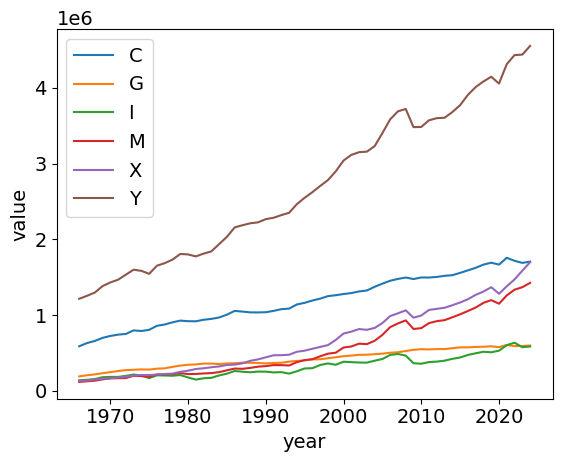

In [ ]:
ages = list(range(18, 66))  # 18-65 inclusive

working_pop = BEFOLK1[BEFOLK1.ALDER.isin(ages)].groupby('year').sum()
working_pop = working_pop.drop(columns=['ALDER'])
working_pop = working_pop.rename(columns={'population':'working_population'})

merged = pd.merge(nah1, working_pop, how='left', on=['year'])
merged = pd.merge(merged, pop, how='left', on=['year'])

import matplotlib.pyplot as plt
def plot(df,variable='value'):
    df_indexed = df.set_index('year')
    I = df_indexed.unit == 'real'
    df_indexed[I].groupby(['variable'])[variable].plot(legend=True);
    plt.ylabel(variable)
    plt.xlabel('year')
    plt.grid()
    plt.show()  
plot(merged,variable='value')
def first(x): # select the first element in a series
    return x.iloc[0]
nah1_alt = nah1.copy()
grouped = nah1_alt.groupby(['variable','unit'])
nah1_alt['first_value'] = grouped['value'].transform(lambda x: x.iloc[
0])

### 2.3. <a id='toc2_3_'></a>[Split-apply-combine-plot](#toc0_)

Ensure the following code for a **split-apply-combine-plot** can run.

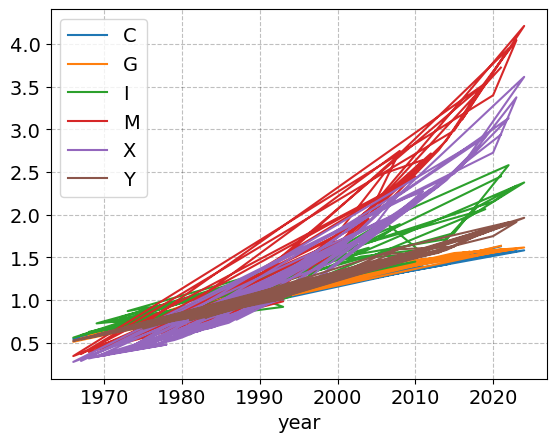

In [376]:
# a. split
nah1_true_grouped = nah1_true.groupby(['variable','unit'])
nah1_true_grouped_first = nah1_true_grouped.value.first()
nah1_true_grouped_first.name = 'first'

# b. apply
nah1_true = nah1_true.set_index(['variable','unit','year'])
nah1_true = nah1_true.join(nah1_true_grouped_first,how='left',on=['variable','unit'])
nah1_true = nah1_true.reset_index()

# c. combine
nah1_true['indexed'] = nah1_true['value']/nah1_true['first']

# d. plot
def plot(df,variable='indexed'):
    df_indexed = df.set_index('year')
    I = df_indexed.unit == 'real'
    df_indexed[I].groupby(['variable'])[variable].plot(legend=True);
    
plot(nah1_true)

**Question:** Implement the same split-apply-combine as above using `transform`.

In [377]:
def first(x): # select the first element in a series
    return x.iloc[0]

nah1_alt = nah1.copy()
grouped = nah1_alt.groupby(['variable','unit'])
nah1_alt['first_value'] = grouped['value'].transform(lambda x: x.iloc[0])
nah1_alt.head()



,variable,unit,year,value,first_value
1970,M,real,1966,116721,116721
1964,X,real,1966,129917,129917
1955,I,nominal,1966,21134,21134
1954,I,real,1966,137948,137948
1945,G,nominal,1966,14768,14768


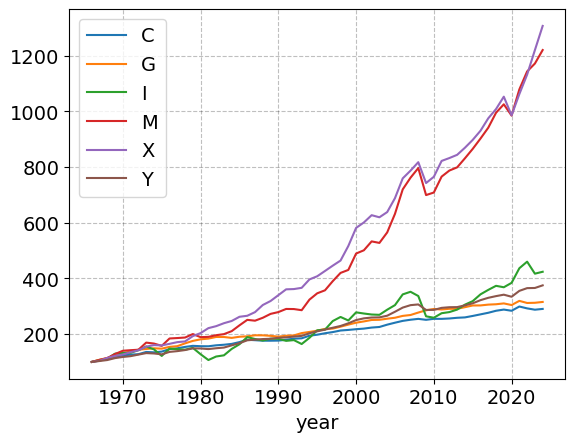

In [378]:
nah1_alt['index_transform'] = (nah1_alt['value'] / nah1_alt['first_value']) * 100
plot(nah1_alt,variable='index_transform')
plt.legend()
plt.show()